We are trying to solve: <br><br>
$\frac{\partial u(x,y,z)}{\partial x} = A(\frac{\partial^{2} u}{\partial z^{2}}+\frac{\partial^{2} u}{\partial y^{2}}) + F(x,y,z)u$<br><br><br>
Using ADI, this becomes two half step updates (eq 3.25, [Fuhse thesis](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=2ahUKEwj11OzNzOXdAhWM1IMKHQeFBfwQFjAAegQICRAC&url=https%3A%2F%2Fediss.uni-goettingen.de%2Fbitstream%2Fhandle%2F11858%2F00-1735-0000-0006-B592-3%2Ffuhse.pdf%3Fsequence%3D1&usg=AOvVaw1HRt8mkDnQc_LoM-RhOpcu)), with the first one being : <br><br>
$(1-\frac{r_{y}}{2}\delta^{2}_{y}+C^{n+\frac{1}{2}}_{jk})*u^{n+\frac{1}{2}}_{jk} = (1+\frac{r_{z}}{2}\delta^{2}_{z}+C^{n}_{jk})*u^{n}_{jk}$<br><br>
This can be written as a series of linear matrix equations :<br><br>
$B^{n}_{k}*u^{n+\frac{1}{2}}_{k} = r_{k}$, for $k = 1,....., M_{z}-1$<br><br>
and for the second half step, it becomes:<br><br>
$B^{'n}_{j}*u^{n+1}_{j} = r^{'}_{j}$, for $k = 1,....., M_{z}-1$<br>
<br><br>
Define: <br><br>
$r_{y} = A\frac{\Delta x}{\Delta y^{2}}$<br>
$r_{z} = A\frac{\Delta x}{\Delta z^{2}}$<br>
$C^{n}_{jk} = \frac{F^{n}_{k}\Delta x}{4}$<br>
$A = \frac{-i}{2k}$<br>
$F(x,y,z) = -1*\frac{ik}{2}(n^{2}(x,y,z)-1)$

In [1]:
import numpy as np
import urllib
import matplotlib.pyplot as plt
from skimage.restoration import unwrap_phase
from tqdm import trange
from scipy.signal import gaussian
from scipy.sparse import diags
import scipy.sparse.linalg as splinalg
import os,pickle
np.set_printoptions(2)

In [2]:
def get_property(mat,energy):
    url = "http://henke.lbl.gov/cgi-bin/pert_cgi.pl"
    data = {'Element':str(mat), 'Energy':str(energy), 'submit':'Submit Query'}
    data = urllib.parse.urlencode(data)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    resp = urllib.request.urlopen(req)
    respDat = resp.read()
    response = respDat.split()
    d =  b'g/cm^3<li>Delta'
    i = response.index(d)
    delta = str(response[i+2])[:str(response[i+2]).index('<li>Beta')][2:]
    beta = str(response[i+4])[2:-1]
    return float(delta),float(beta)

In [3]:
def make_zp_from_rings(n,grid_size):
    zp = np.zeros((grid_size,grid_size))
    for i in range(n):
        if i%2 == 1 :
            locs_ = np.load('ring_locs_'+str(i)+'.npy')
            locs_ = tuple((locs_[0],locs_[1]))
            vals_ = np.load('ring_vals_'+str(i)+'.npy')
            zp[locs_] = vals_
    return zp

grid_size  :  5000
step_xy  :  2.800560112021502e-08
energy(in eV)  :  500
wavelength in m  :  2.47968e-09
focal_length  :  0.0015
zp_coords  :  [-7e-05, 7e-05, -7e-05, 7e-05]
delta  :  0.0048625
beta  :  0.004763


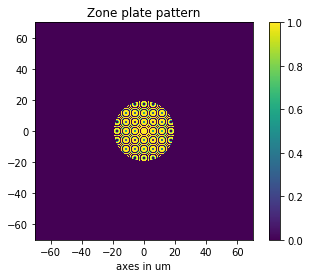

In [4]:
os.chdir(os.getcwd()+str('/zp_make/rings'))
parameters = pickle.load(open('parameters.pickle','rb'))
for i in parameters : print(i,' : ',parameters[i])
zp_coords = parameters['zp_coords']
grid_size = parameters['grid_size']
zp = make_zp_from_rings(100,int(grid_size))
plt.imshow(zp,extent=np.array(zp_coords)*1e6)
plt.title('Zone plate pattern')
plt.xlabel('axes in um')
plt.colorbar()
plt.show()

In [5]:
E = 500
wavel = (1239.84/E)*1e-9
k = ((2*np.pi)/wavel)
A = -1j/(2*k)

In [6]:
dim_x = 4
dim_y = 5000
dim_z = 5000

x = np.linspace(0,10e-6,dim_x)
y = np.linspace(-70e-6,70e-6,dim_y)
z = np.linspace(-70e-6,70e-6,dim_z)

Δx = x[1] - x[0]
Δy = y[1] - y[0]
Δz = z[1] - z[0]


r_y = A * (Δx/(Δy)**2) 
r_z = A * (Δx/(Δz)**2) 

coords = [y[0]*1e6,y[-1]*1e6,z[0]*1e6,z[-1]*1e6]
n_au = 1 - get_property('Au',E)[0] - 1j*get_property('Au',E)[1]

In [7]:
F = np.zeros((dim_x,dim_y,dim_z),dtype=np.complex128)

In [8]:
for i in range(dim_x):
    F[i,:,:] = -1j*(k/2)*(1-(zp*n_au)**2)

In [9]:
wave = np.ones((dim_y,dim_z),dtype=np.complex128)
wave_new = np.ones((dim_y,dim_z),dtype=np.complex128)
Y,Z = np.meshgrid(y,z)
wave_history = np.ones((dim_x,dim_y,dim_z),dtype=np.complex128)

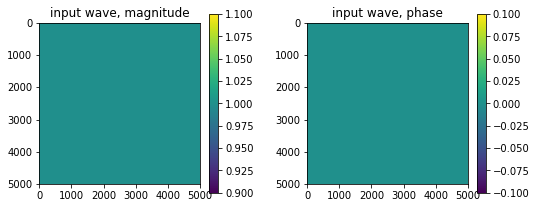

In [10]:
plt.rcParams["figure.figsize"] = (8,8)
fig,(ax1,ax2) = plt.subplots(1,2)
im1 = ax1.imshow(np.abs(wave))
ax1.set_title('input wave, magnitude')
fig.colorbar(im1, ax=ax1,fraction=0.05)
im2 = ax2.imshow(unwrap_phase(np.angle(wave)))
ax2.set_title('input wave, phase')
fig.colorbar(im2, ax=ax2,fraction=0.05)
fig.subplots_adjust(wspace=0.5)
plt.show()

In [11]:
def step_1(wave_new,wave,B,dim_z,r_y,r_z,k):
    c = ((Δx/4)*F[i,1:-1,k])
    d = wave[1:-1,k]*(1+c) + (r_z/2)*(wave[1:-1,k-1]-2*wave[1:-1,k]+wave[1:-1,k+1])
    d[0]  += (r_y/2)*wave[0,k]
    d[-1] += (r_y/2)*wave[-1,k]
    B = B - diags(c,offsets=0)
    wave_new[1:-1,k] = splinalg.spsolve(B,d)

def step_2(wave_new,wave,B,dim_y,r_y,r_z,j):
    c = ((Δx/4)*F[i,j,1:-1])
    d = wave[j,1:-1]*(1+c) + (r_y/2)*(wave[j-1,1:-1]-2*wave[j,1:-1]+wave[j+1,1:-1])
    d[0]  += (r_z/2)*wave[j,0]
    d[-1] += (r_z/2)*wave[j,-1]
    B = B - diags(c,offsets=0)
    wave_new[j,1:-1] = splinalg.spsolve(B,d)

In [12]:
for i in trange(dim_x):
    b_diag = np.ones(dim_z-2)*(1 + r_y)
    B = diags(b_diag,offsets=0) + diags(-r_y/2*np.ones(dim_z-3),offsets=1) + diags(-r_y/2*np.ones(dim_z-3),offsets=-1)
    for k in range(1,dim_z-1):
        step_1(wave_new,wave,B,dim_z,r_y,r_z,k)

    b_diag = np.ones(dim_y-2)*(1 + r_z)
    B = diags(b_diag,offsets=0) + diags(-r_z/2*np.ones(dim_y-3),offsets=1) + diags(-r_z/2*np.ones(dim_y-3),offsets=-1) 
    for j in range(1,dim_y-1):
        step_2(wave,wave_new,B,dim_y,r_y,r_z,j)
    
    wave_history[i,1:-1,1:-1] = wave[1:-1,1:-1]

100%|██████████| 4/4 [03:25<00:00, 51.31s/it]


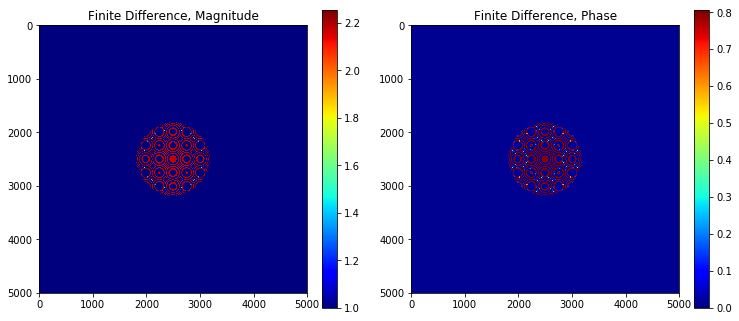

In [13]:
plt.rcParams["figure.figsize"] = (12,12)
fig,(ax1,ax2) = plt.subplots(1,2)

im1 = ax1.imshow(np.abs(wave_history[-1,:,:]),cmap='jet')
ax1.set_title('Finite Difference, Magnitude')
fig.colorbar(im1, ax=ax1,fraction=0.05)

im2 = ax2.imshow(unwrap_phase(np.angle(wave_history[-1,:,:])),cmap='jet')
ax2.set_title('Finite Difference, Phase')
fig.colorbar(im2, ax=ax2,fraction=0.05)

fig.subplots_adjust(hspace=0.25)
fig.subplots_adjust(wspace=0.25)
plt.show()

In [14]:
from multislice import prop,prop_utils
wave_exit = wave_history[-1,:,:]

In [15]:
step_z = 1.5e-3
L = Δy*dim_y
p = prop_utils.decide(step_z,Δy,L,wavel)
print('Propagation to focal plane')
print('Fresnel Number :',((L**2)/(wavel*step_z)))
wave_focus,L2 = p(wave_exit - np.ones(np.shape(wave_exit)),Δy,L,wavel,step_z)
wave_focus = wave_focus +  np.ones(np.shape(wave_exit))

propogator to be used : Transfer Function
Propagation to focal plane
Fresnel Number : 5271.605570781633


In [16]:
focal_spot_size = 25
focal_spot,x_,y_,max_val = prop_utils.get_focal_spot(np.abs(wave_focus),grid_size,focal_spot_size)

max_loc : 2499 2499 25 25


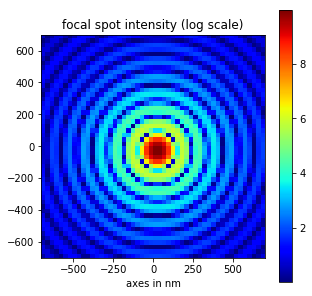

In [17]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(np.log(focal_spot**2+1),extent = np.array([-1,1,-1,1])*(focal_spot_size)*(L2/grid_size)*(1e9),cmap='jet')
plt.title('focal spot intensity (log scale)')
plt.xlabel('axes in nm')
plt.colorbar()
plt.show()